In [46]:
from scipy.special import erfc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import diags
%matplotlib inline

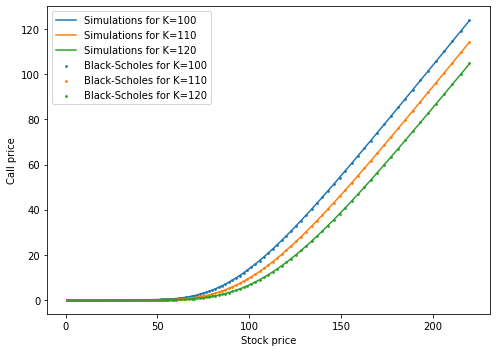

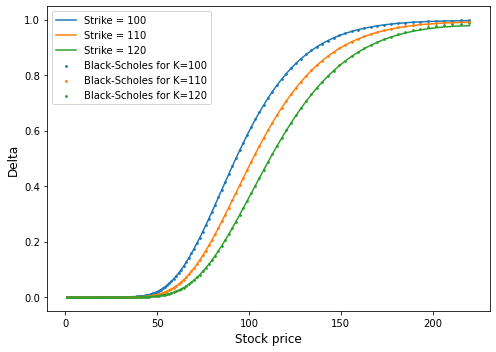

In [255]:
class FTCS():
    def __init__(self,Ks):
        self.x_max = np.log(220) # ????
        self.t_max = 1 # total time in yr
        self.dt = 0.004 # grid size for time 
        self.dx = self.dt*self.x_max/self.t_max # grid size for x
        self.sigma = 0.3
        self.r = 0.04
        plt.figure(figsize=(7,5))
        for K in Ks:
            self.K=K
            self.plot(plot=True)
        plt.tight_layout()
        plt.savefig('FTCS.pdf')
        plt.figure(figsize=(7,5))
        for K in Ks:
            self.K=K
            self.plot_delta(plot=True)
        plt.tight_layout()
        plt.savefig('FTCS_delta.pdf')
    # function to calculate call profiles based on a 
    # finite difference approximation to the 1D 
    # equation and the FTCS scheme:
    
    def call_FTCS(self,dt,dx,t_max,x_max,r,sigma):
        # diffusion number (has to be less than 0.5 for the 
        # solution to be stable):
        b1 = (r-(self.sigma**2)/2)*(self.dt/(2*self.dx)) + ((self.sigma**2)/2)*(self.dt/(self.dx**2))
        b0 = 1 - (self.sigma**2)*(self.dt/(self.dx**2)) - self.r*self.dt
        b_1 = ((self.sigma**2)/2)*(self.dt/(self.dx**2)) - (self.r-(self.sigma**2)/2)*(self.dt/(2*self.dx))
        x = np.arange(0,self.x_max+self.dx,self.dx) 
        t = np.arange(0,self.t_max+self.dt,self.dt)
        S = np.exp(x)

        T = len(t)
        X = len(x)
        V = np.zeros([T,X])
        # boundary and initial conditions
        V[:,0] = np.max(np.vstack((np.zeros(len(x)),np.exp(x[0])-self.K*np.exp(-self.r*t))),axis=0)
        V[:,X-1] = np.exp(self.x_max) - self.K*np.exp(-self.r*t)
        V[0,:] = np.max(np.vstack((np.zeros(len(x)),np.exp(x)-self.K)),axis=0)
        for n in range(0,T-1): # time
            for j in range(1,X-1): # space
                V[n+1,j] = b1*V[n,j+1] + b0*V[n,j] + b_1*V[n,j-1]

        return S,V
    # note that this can be written without the for-loop 
    # in space, but it is easier to read it this way

    def black_scholes(self,S, call_put='call'):   
        """Return black scholes price of an option"""
        #S: spot price
        #K: strike price
        #T: time to maturity
        #r: interest rate
        #sigma: volatility of underlying asset
        d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t_max) / (self.sigma * np.sqrt(self.t_max))
        d2 = (np.log(S / self.K) + (self.r - 0.5 * self.sigma ** 2) * self.t_max) / (self.sigma * np.sqrt(self.t_max))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - self.K * np.exp(-self.r * self.t_max) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (self.K * np.exp(-self.r * self.t_max) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        return optionprice

    def plot(self,plot=False):
        S,V = self.call_FTCS(self.dt,self.dx,self.t_max,self.x_max,self.r,self.sigma)
        # plotting:
        #/plt.figure(figsize=(7,5))
        plot_times = [1]#np.arange(self.dt,self.t_max,100*self.dt)

        for t in plot_times:
            plt.plot(S,V[int(t/self.dt),:], label='Simulations for K='+str(self.K))
            V_bs = self.black_scholes(S)
            plt.scatter(S,V_bs,label='Black-Scholes for K='+str(self.K),
                    s=3)
            if t==self.dt:
                plt.legend(fontsize=10)
        plt.xlabel('Stock price',fontsize=10)
        plt.ylabel('Call price',fontsize=10)
        plt.legend()
        
    def plot_delta(self,plot=False):
        # numerical delta
        S,V = self.call_FTCS(self.dt,self.dx,self.t_max,self.x_max,self.r,self.sigma)
        V = V[int(1/self.dt),:]
        delta_y = np.diff(V)
        delta_x = np.diff(S)
        delta = delta_y / delta_x
        
        # black scholes delta
        V_bs = self.black_scholes(S)
        
        delta_y_bs = np.diff(V_bs)
        delta_bs = delta_y_bs / delta_x
        
        # plot delta's
        plt.plot(S[:-1]+np.diff(S),delta,label='Strike = '+str(self.K))
        plt.scatter(S[:-1]+np.diff(S),delta_bs,label='Black-Scholes for K='+str(self.K),
                    s=3)
        plt.xlabel('Stock price',fontsize=12)
        plt.ylabel('Delta',fontsize=12)
        # plt.axis([0,np.exp(x_max),0,V[0]])
        plt.legend()



        
FTCSengine=FTCS([100,110,120])


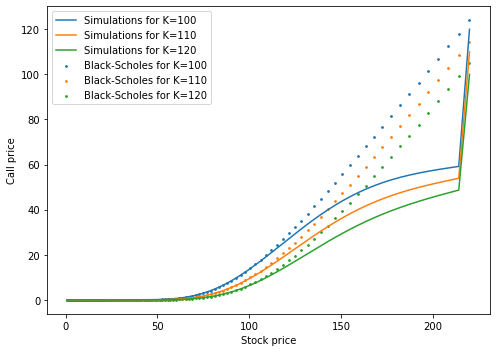

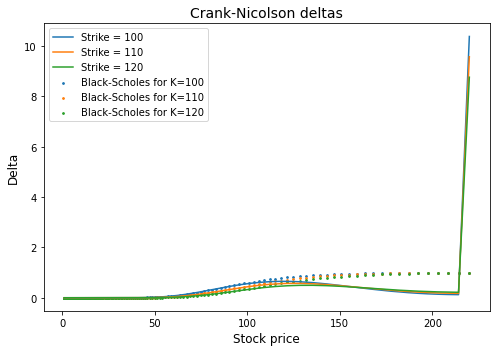

In [260]:
class CrankNicolson():
    def __init__(self,Ks):
        self.x_max = np.log(220) # ????
        self.t_max = 1 # total time in yr
        self.dt = 0.005 # grid size for time 
        self.dx = self.dt*self.x_max/self.t_max # grid size for x
        self.sigma = 0.3
        self.r = 0.04
        plt.figure(figsize=(7,5))
        for K in Ks:
            self.K=K
            self.plot(plot=True)
        plt.tight_layout()
        plt.savefig('CrankNicolson.pdf')
        plt.figure(figsize=(7,5))
        for K in Ks:
            self.K=K
            self.plot_delta(plot=True)
        plt.tight_layout()
        plt.savefig('CN_delta.pdf')   
        
    def explicit_scheme(self,x,nx,steps):
        # diffusion number (has to be less than 0.5 for the 
        # solution to be stable):
        b1 = (r-(self.sigma**2)/2)*(self.dt/(2*self.dx)) + ((self.sigma**2)/2)*(self.dt/(self.dx**2))
        b0 = 1 - (self.sigma**2)*(self.dt/(self.dx**2)) - self.r*self.dt
        b_1 = ((self.sigma**2)/2)*(self.dt/(self.dx**2)) - (self.r-(self.sigma**2)/2)*(self.dt/(2*self.dx))
        
        t = np.arange(0, steps*self.dt, self.dt)
        V = np.zeros([steps,nx])
        # boundary and initial conditions
        V[:,0] = np.max(np.vstack((np.zeros(len(t)),np.exp(x[0])-self.K*np.exp(-self.r*t))),axis=0)
        V[:,nx-1] = np.exp(self.x_max) - self.K*np.exp(-self.r*t)
        V[0,:] = np.max(np.vstack((np.zeros(len(x)),np.exp(x)-self.K)),axis=0)
        for n in range(0,steps-1): # time
            for j in range(1,nx-1): # space
                V[n+1,j] = b1*V[n,j+1] + b0*V[n,j] + b_1*V[n,j-1]
        
        Vstart = V[steps-1,:]
        
        return Vstart
    
    def call_CN(self):
        # define the constants of the scheme
        a1 = -(self.r-(self.sigma**2)/2)*(self.dt/(4*self.dx)) - ((self.sigma**2)/4)*(self.dt/(self.dx**2))
        a0 = 1 + ((self.sigma**2)/2)*(self.dt/(self.dx**2)) + self.r*self.dt
        a_1 = (self.r-(self.sigma**2)/2)*(self.dt/(4*self.dx)) - ((self.sigma**2)/4)*(self.dt/(self.dx**2))
        b1 = (self.r-(self.sigma**2)/2)*(self.dt/(4*self.dx)) + ((self.sigma**2)/4)*(self.dt/(self.dx**2))
        b0 = 1 - ((self.sigma**2)/2)*(self.dt/(self.dx**2))
        b_1 = ((self.sigma**2)/4)*(self.dt/(self.dx**2)) - (self.r-(self.sigma**2)/2)*(self.dt/(4*self.dx))
        
        x = np.arange(0,self.x_max+self.dx,self.dx) 
        S = np.exp(x)
        nx = len(x)
        nt = nx
             
        V = np.zeros((nx))
        # initial condition
        V = np.max(np.vstack((np.zeros(len(x)),S-self.K)),axis=0) # initial condition
        # create coefficient matrix:
        A = diags([a_1, a0, a1], [-1, 0, 1], 
              shape=(nx-2, nx-2)).toarray() 
        B1 = diags([b_1, b0, b1],[-1, 0, 1], shape=(nx-2, nx-2)).toarray()
        for n in range(1,int(1/self.dt)): # time is going from second time step to last
            # boundary conditions
            Vn = V
            B = np.dot(Vn[1:-1],B1) 
#             V[0] = 0
#             V[-1] = np.exp(self.x_max) - self.K*np.exp(-self.r*((n+1)*self.dt))
            B[0] = B[0] - a_1*V[0]
            B[-1] = B[-1] - a1*V[-1]
            V[1:-1] = np.linalg.solve(A,B)

        return S, V

    def black_scholes(self,S, call_put='call'):   
        """Return black scholes price of an option"""
        #S: spot price
        #K: strike price
        #T: time to maturity
        #r: interest rate
        #sigma: volatility of underlying asset
        d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t_max) / (self.sigma * np.sqrt(self.t_max))
        d2 = (np.log(S / self.K) + (self.r - 0.5 * self.sigma ** 2) * self.t_max) / (self.sigma * np.sqrt(self.t_max))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - self.K * np.exp(-self.r * self.t_max) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (self.K * np.exp(-self.r * self.t_max) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        return optionprice

    def plot(self,plot=False):
        S,Vout = self.call_CN()
        plt.plot(S,Vout, label='Simulations for K='+str(self.K))
        V_bs = self.black_scholes(S)
        plt.scatter(S,V_bs,label='Black-Scholes for K='+str(self.K),
                    s=3)
        plt.legend(fontsize=10)
        plt.xlabel('Stock price',fontsize=10)
        plt.ylabel('Call price',fontsize=10)
        plt.legend()
        
    def plot_delta(self,plot=False):
        # numerical delta
        S,V = self.call_CN()
        delta_y = np.diff(V)
        delta_x = np.diff(S)
        delta = delta_y / delta_x
        
        # black scholes delta
        V_bs = self.black_scholes(S)
        delta_y_bs = np.diff(V_bs)
        delta_bs = delta_y_bs / delta_x
        
        # plot delta's
        plt.plot(S[:-1]+np.diff(S),delta,label='Strike = '+str(self.K))
        plt.scatter(S[:-1]+np.diff(S),delta_bs,label='Black-Scholes for K='+str(self.K),
                    s=3)
        plt.xlabel('Stock price',fontsize=12)
        plt.ylabel('Delta',fontsize=12)
        plt.legend()
        plt.title('Crank-Nicolson deltas',fontsize=14)
        plt.legend()
        


CNengine=CrankNicolson([100,110,120])

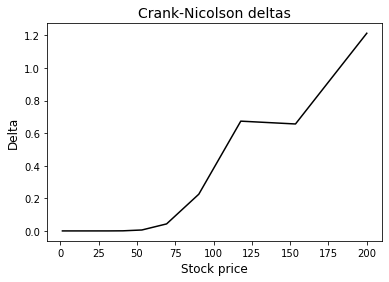

In [32]:
def delta_CN():
    delta_y = np.diff(V)
    delta_x = np.diff(S)
    delta = delta_y / delta_x
    plt.plot(S[:-1]+np.diff(S),delta,color='black')
    plt.xlabel('Stock price',fontsize=12)
    plt.ylabel('Delta',fontsize=12)
    # plt.axis([0,np.exp(x_max),0,V[0]])
    plt.title('Crank-Nicolson deltas',fontsize=14);
delta_CN()

In [141]:
V = [1, 2, 3, 4, 5, 6]
print(V[1:-1])

[2, 3, 4, 5]
